# Tutorial IV: Constructing variational algorithms

Variational quantum algorithms are a broad set of methods which involve optimizing a parameterized quantum circuit ansatz applied to some initial state (called the "reference") in order to minimize a cost function defined with respect to the output state. In the context of quantum simulation, very often the goal is to prepare ground states and the cost function is the expectation value of a Hamiltonian. Thus, if we define the reference (initial state) as $\lvert \psi\rangle$, the Hamiltonian as $H$ and the parameterized quantum circuit as $U(\vec{\theta})$ where $\vec{\theta}$ are the varaitional parameters, then the goal is to minimize the cost function
$$
E(\vec \theta) =  \langle \psi \rvert
U^\dagger(\vec{\theta}) H U(\vec{\theta})
\lvert \psi\rangle.
$$
A classical optimization algorithm can be used to find the $\vec{\theta}$ that minimizes the value of the expression. The performance of a variational algorithm depends crucially on the choice of ansatz circuit $U(\vec{\theta})$, the choice of reference, and the strategy for choosing the initial parameters $\vec{\theta}$ since typically global optimizing is challenging and one needs to begin reasonably close to the intended state. One possibility is to use an ansatz of the form
$$
U(\vec{\theta}) = \prod_j \exp(-i \theta_j H_j)
$$
where the $H = \sum_j H_j$. This ansatz is inspired by a low Trotter-number Trotter-Suzuki based approximation to adiabatic state preparation. OpenFermion-Cirq contains routines for constructing ansatzes of this form which use as templates the Trotter step algorithms implemented in the `trotter` module.

### Jellium with a Linear Swap Network

We will first demonstrate the construction and optimization of a variational ansatz for a jellium Hamiltonian. We will use an ansatz based on the `LINEAR_SWAP_NETWORK` Trotter step, which takes as input a DiagonalCoulombHamiltonian. Later, we will show how one can create a custom circuit ansatz and apply it to the H$_2$ molecule in a minimal basis.

In [1]:
import openfermion
import openfermioncirq

# Set parameters of jellium model.
wigner_seitz_radius = 5. # Radius per electron in Bohr radii.
n_dimensions = 2 # Number of spatial dimensions.
grid_length = 2 # Number of grid points in each dimension.
spinless = True # Whether to include spin degree of freedom or not.
n_electrons = 2 # Number of electrons.

# Figure out length scale based on Wigner-Seitz radius and construct a basis grid.
length_scale = openfermion.wigner_seitz_length_scale(
    wigner_seitz_radius, n_electrons, n_dimensions)
grid = openfermion.Grid(n_dimensions, grid_length, length_scale)

# Initialize the model and compute its ground energy in the correct particle number manifold
fermion_hamiltonian = openfermion.jellium_model(grid, spinless=spinless, plane_wave=False)
hamiltonian_sparse = openfermion.get_sparse_operator(fermion_hamiltonian)
ground_energy, _ = openfermion.jw_get_ground_state_at_particle_number(
    hamiltonian_sparse, n_electrons)
print('The ground energy of the jellium Hamiltonian at {} electrons is {}'.format(
    n_electrons, ground_energy))

# Convert to DiagonalCoulombHamiltonian type.
hamiltonian = openfermion.get_diagonal_coulomb_hamiltonian(fermion_hamiltonian)

# Define the objective function
objective = openfermioncirq.HamiltonianObjective(hamiltonian)

# Create a swap network Trotter ansatz.
iterations = 1  # This is the number of Trotter steps to use in the ansatz.
ansatz = openfermioncirq.SwapNetworkTrotterAnsatz(
    hamiltonian,
    iterations=iterations)

print('Created a variational ansatz with the following circuit:')
print(ansatz.circuit.to_text_diagram(transpose=True))

The ground energy of the jellium Hamiltonian at 2 electrons is -0.2697672439172563
Created a variational ansatz with the following circuit:
0       1            2         3
│       │            │         │
XXYY────XXYY^T_0_1_0 XXYY──────XXYY^T_2_3_0
│       │            │         │
@───────@^V_0_1_0    @─────────@^V_2_3_0
│       │            │         │
×ᶠ──────×ᶠ           ×ᶠ────────×ᶠ
│       │            │         │
│       @────────────@^V_0_3_0 │
│       │            │         │
│       ×ᶠ───────────×ᶠ        │
│       │            │         │
XXYY────XXYY^T_1_3_0 XXYY──────XXYY^T_0_2_0
│       │            │         │
@───────@^V_1_3_0    @─────────@^V_0_2_0
│       │            │         │
×ᶠ──────×ᶠ           ×ᶠ────────×ᶠ
│       │            │         │
Z^U_3_0 @────────────@^V_1_2_0 Z^U_0_0
│       │            │         │
│       ×ᶠ───────────×ᶠ        │
│       │            │         │
│       Z^U_2_0      Z^U_1_0   │
│       │            │         │
│       @────────────@

In the last lines above we instantiated a class called SwapNetworkTrotterAnsatz which inherits from the general VariationalAnsatz class in OpenFermion-Cirq. A VariationalAnsatz is essentially a parameterized circuit that one constructs so that parameters can be supplied symbolically. This way one does not (necessarily) need to recompile the circuit each time the variational parameters change. We also instantiated a HamiltonianObjective which represents the objective function being the expectation value of our Hamiltonian.

Optimizing an ansatz requires the creation of a VariationalStudy object. A VariationalStudy is responsible for performing optimizations and storing the results. By default, it evaluates parameters by simulating the quantum circuit and computing the objective function, in this case the expectation value of the Hamiltonian, on the final state. It includes an optional state preparation circuit to be applied prior to the ansatz circuit. For this example, we will prepare the initial state as an eigenstate of the one-body operator of the Hamiltonian. Since the one-body operator is a quadratic Hamiltonian, its eigenstates can be prepared using the `prepare_gaussian_state` method. The SwapNetworkTrotterAnsatz class also includes a default setting of parameters which is inspired by the idea of state preparation by adiabatic evolution from the mean-field state.

In [2]:
# Use preparation circuit for mean-field state
import cirq
preparation_circuit = cirq.Circuit(
    openfermioncirq.prepare_gaussian_state(
        ansatz.qubits,
        openfermion.QuadraticHamiltonian(hamiltonian.one_body),
        occupied_orbitals=range(n_electrons)))

# Create a Hamiltonian variational study
study = openfermioncirq.VariationalStudy(
    'jellium_study',
    ansatz,
    objective,
    preparation_circuit=preparation_circuit)

print("Created a variational study with {} qubits and {} parameters".format(
    len(study.ansatz.qubits), study.num_params))

print("The value of the objective with default initial parameters is {}".format(
    study.value_of(ansatz.default_initial_params())))

print("The circuit of the study is")
print(study.circuit.to_text_diagram(transpose=True))

Created a variational study with 4 qubits and 14 parameters
The value of the objective with default initial parameters is -0.19655859516666632
The circuit of the study is
0       1            2         3
│       │            │         │
X       X            │         │
│       │            │         │
│       YXXY─────────#2^0.995  │
│       │            │         │
YXXY────#2^-0.502    Z^0       │
│       │            │         │
│       Z^0          YXXY──────#2^-0.498
│       │            │         │
│       YXXY─────────#2^0.005  Z^0
│       │            │         │
│       │            Z^0       │
│       │            │         │
XXYY────XXYY^T_0_1_0 XXYY──────XXYY^T_2_3_0
│       │            │         │
@───────@^V_0_1_0    @─────────@^V_2_3_0
│       │            │         │
×ᶠ──────×ᶠ           ×ᶠ────────×ᶠ
│       │            │         │
│       @────────────@^V_0_3_0 │
│       │            │         │
│       ×ᶠ───────────×ᶠ        │
│       │            │         │
XXYY───

As we can see, our initial guess isn't particularly close to the target energy. Optimizing the study requires the creation of an OptimizationParams object. The most import component of this object is the optimization algorithm to use. OpenFermion-Cirq includes a wrapper around the the `minimize` method of Scipy's `optimize` module and more optimizers will be included in the future. Let's perform an optimization using the COBYLA method. Since this is just an example, we will set the maximum number of function evaluations to 100 so that it doesn't run too long.

In [3]:
# Perform an optimization run.
from openfermioncirq.optimization import ScipyOptimizationAlgorithm, OptimizationParams
algorithm = ScipyOptimizationAlgorithm(
    kwargs={'method': 'COBYLA'},
    options={'maxiter': 100},
    uses_bounds=False)
optimization_params = OptimizationParams(
    algorithm=algorithm)
result = study.optimize(optimization_params)
print(result.optimal_value)

-0.2693602901295287


In practice, the expectation value of the Hamiltonian cannot be measured exactly due to errors from finite sampling. This manifests as an error, or noise, in the measured value of the energy which can be reduced at the cost of more measurements. The HamiltonianVariationalStudy class incorporates a realistic model of this noise (shot-noise). The OptimizationParams object can have a `cost_of_evaluate` parameter which in this case represents the number of measurements used to estimate the energy for a set of parameters. If we are interested in how well an optimizer performs in the presence of noise, then we may want to repeat the optimization several times and see how the results vary between repetitions.

Below, we will perform the same optimization, but this time using the noise model. We will allow one million measurements per energy evaluation and repeat the optimization three times. Since this time the function evaluations are noisy, we'll also indicate that the final parameters of the study should be reevaluated according to a noiseless simulation. Finally, we'll print out a summary of the study, which includes all results obtained so far (including from the previous cell).

In [4]:
optimization_params = OptimizationParams(
    algorithm=algorithm,
    cost_of_evaluate=1e6)
study.optimize(
    optimization_params,
    identifier='COBYLA with maxiter=100, noisy',
    repetitions=3,
    reevaluate_final_params=True,
    use_multiprocessing=True)
print(study)

This study contains 2 trial results.
The optimal value found among all trial results is -0.2693602901295287.
It was found by the run with identifier 0.
Result details:
    Identifier: 0
        Optimal value: -0.2693602901295287
        Number of repetitions: 1
        Optimal value 1st, 2nd, 3rd quartiles:
            [-0.2693602901295287, -0.2693602901295287, -0.2693602901295287]
        Num evaluations 1st, 2nd, 3rd quartiles:
            [100.0, 100.0, 100.0]
        Cost spent 1st, 2nd, 3rd quartiles:
            [nan, nan, nan]
        Time spent 1st, 2nd, 3rd quartiles:
            [0.6766312122344971, 0.6766312122344971, 0.6766312122344971]
    Identifier: COBYLA with maxiter=100, noisy
        Optimal value: -0.2678661682532
        Number of repetitions: 3
        Optimal value 1st, 2nd, 3rd quartiles:
            [-0.2670300806160921, -0.2661939929789843, -0.2650438210386521]
        Num evaluations 1st, 2nd, 3rd quartiles:
            [100.0, 100.0, 100.0]
        Cost spen

We see then that in the noisy study the optimizer fails to converge to the final result with high enough accuracy. Apparently then one needs more measurements, a more stable optimizer, or both!

### H$_2$ with a custom ansatz

The above example shows one of the nice built-in ansatz offered in OpenFermion-Cirq that can be applied to many different types of physical systems without the need for much input by the user.  In some research cases, however, one may wish to design their own paramterized ansatz.  Here will give an example of how to do this for the simple case of the H$_2$ molecule in a minimal basis.

To provide some brief background, in a minimal basis H$_2$ is discretized into two slater-type spatial orbitals, each of which is expressed as a sum of 3 Gaussians (STO-3G).  After pre-processing with a mean-field, Hartree-Fock, procedure, the best meanfield approximation of the ground state is found to be the symmetric superposition of these two spatial orbitals.  After including spin in the problem by assigning each spatial orbital an alpha and beta spin, or equivalently the tensor product of the spatial and spin-$1/2$ degree of freedom, the mean-field state is expressed as
\begin{equation}
\vert \Psi_{\text{initial}} \rangle = a^\dagger_1 a^\dagger_0 \vert \rangle.
\end{equation}

Within the Jordan-Wigner encoding of fermionic systems, this is equivalent to a computational basis state with the first two qubits being in the 1 state and the second two qubits in the 0 state.  This can be prepared via a simple circuit as
\begin{equation}
| \Psi_{\text{initial}} \rangle = X_1 X_0 \vert 0 0 0 0 \rangle = \vert 1 1 0 0 \rangle.
\end{equation}

As a result of the symmetries present in this system, only one transition is allowed, and it completely characterizes the freedom required to move from this initial guess to the exact ground state solution for all geometries of H$_2$ in the minimal basis.  That is the concerted transitions of electrons from spin-orbitals 0, 1 to 2, 3.  This corresponds to the fermionic operator $a_3^\dagger a_2^\dagger a_1 a_0$, which is of course not unitary, but one may lift this operation to the anti-hermitian generator of a rotation as in unitary coupled cluster to yield the unitary
\begin{equation}
\exp \left[ \theta \left(a_3^\dagger a_2^\dagger a_1 a_0 - a_0^\dagger a_1^\dagger a_2 a_3\right) \right]
\end{equation}

which may be decomposed exactly using a combination of the Jordan-Wigner transformation and standard identites from Nielsen and Chuang.  However, as has been noted before, the essential action of concerted electron movement can be captured in only a single of the Jordan-Wigner terms, hence the simpler operation
\begin{equation}
\exp \left[ -i \theta Y_3 X_2 X_1 X_0 \right]
\end{equation}
suffices.  This is what we use here in combination with standard gate identities to parameterize an ansatz for H$_2$.

In the following code we first load up one example geometry of the H$_2$ molecule, as this data is included with OpenFermion. To compute such Hamiltonians for arbitrary molecules in different basis sets geometries, etc., one can use plugins such as [OpenFermion-Psi4](https://github.com/quantumlib/OpenFermion-PySCF) or [OpenFermion-PySCF](https://github.com/quantumlib/OpenFermion-PySCF). Later we will use these same techniques to load and evaluate the full curve with our ansatz.

In [5]:
import openfermion

diatomic_bond_length = .7414
geometry = [('H', (0., 0., 0.)), 
            ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1
charge = 0
description = format(diatomic_bond_length)

molecule = openfermion.MolecularData(
    geometry,
    basis,
    multiplicity,
    description=description)
molecule.load()

hamiltonian = molecule.get_molecular_hamiltonian()
print("Bond Length in Angstroms: {}".format(diatomic_bond_length))
print("Hartree Fock (mean-field) energy in Hartrees: {}".format(molecule.hf_energy))
print("FCI (Exact) energy in Hartrees: {}".format(molecule.fci_energy))

Bond Length in Angstroms: 0.7414
Hartree Fock (mean-field) energy in Hartrees: -1.116684386906734
FCI (Exact) energy in Hartrees: -1.137270174625328


Now we design a custom ansatz with a single parameter based on the simplfied unitary above.  The ansatz class makes convenient use of named parameters which are specified by the params routine.  The parameterized circuit then makes use of these parameters within its operations method.

In [6]:
import cirq
import openfermioncirq
import sympy

class MyAnsatz(openfermioncirq.VariationalAnsatz):
    
    def params(self):
        """The parameters of the ansatz."""
        return [sympy.Symbol('theta_0')]
    
    def operations(self, qubits):
        """Produce the operations of the ansatz circuit."""
        q0, q1, q2, q3 = qubits
        yield cirq.H(q0), cirq.H(q1), cirq.H(q2)
        yield cirq.XPowGate(exponent=-0.5).on(q3)
        
        yield cirq.CNOT(q0, q1), cirq.CNOT(q1, q2), cirq.CNOT(q2, q3)
        yield cirq.ZPowGate(exponent=sympy.Symbol('theta_0')).on(q3)
        yield cirq.CNOT(q2, q3), cirq.CNOT(q1, q2), cirq.CNOT(q0, q1)
        
        yield cirq.H(q0), cirq.H(q1), cirq.H(q2)
        yield cirq.XPowGate(exponent=0.5).on(q3)

    def _generate_qubits(self):
        """Produce qubits that can be used by the ansatz circuit."""
        return cirq.LineQubit.range(4)

After this custom ansatz is designed, we can instantiate it and package it into a variational study class along with an initial state preparation cirucit that makes it more convenient to study parts of an ansatz.  In this case our initial state is the doubly occupied computational basis state mentioned above.

In [7]:
ansatz = MyAnsatz()
objective = openfermioncirq.HamiltonianObjective(hamiltonian)
q0, q1, _, _ = ansatz.qubits
preparation_circuit = cirq.Circuit(
    cirq.X(q0),
    cirq.X(q1))
study = openfermioncirq.VariationalStudy(
    name='my_hydrogen_study',
    ansatz=ansatz,
    objective=objective,
    preparation_circuit=preparation_circuit)
print(study.circuit)

0: ───X───H────────@───────────────────────────────────@───H───
                   │                                   │
1: ───X───H────────X───@───────────────────────@───────X───H───
                       │                       │
2: ───────H────────────X───@───────────────@───X───────H───────
                           │               │
3: ───────X^-0.5───────────X───Z^theta_0───X───X^0.5───────────


With this this paramterized circuit and state preparation packaged into a variational study, it is now straightfoward to attach an optimizer and find the optimal value as was done in the example above.  Note that we can also set an initial guess for the angle as determined by any number of methods, and we demonstrate this here.  Note that as the built-in simulator for Cirq is based on single precision, the solution may appear sub-variational past this precision due to round off errors that accumlate, however it is far below the accuracy one is typically concerned with for this type of problem.

In [8]:
# Perform optimization.
import numpy
from openfermioncirq.optimization import COBYLA, OptimizationParams
optimization_params = OptimizationParams(
    algorithm=COBYLA,
    initial_guess=[0.01])
result = study.optimize(optimization_params)
print("Initial state energy in Hartrees: {}".format(molecule.hf_energy))
print("Optimized energy result in Hartree: {}".format(result.optimal_value))
print("Exact energy result in Hartees for reference: {}".format(molecule.fci_energy))

Initial state energy in Hartrees: -1.116684386906734
Optimized energy result in Hartree: -1.1372701552464972
Exact energy result in Hartees for reference: -1.137270174625328


Using this same circuit and approach, we can now build a curve for the length of the H$_2$ molecule and plot it in the following way. Note that running the code in the cell above is required for this example.

In [9]:
bond_lengths = ['{0:.1f}'.format(0.3 + 0.1 * x) for x in range(23)]
hartree_fock_energies = []
optimized_energies = []
exact_energies = []

for diatomic_bond_length in bond_lengths:
    geometry = [('H', (0., 0., 0.)), 
                ('H', (0., 0., diatomic_bond_length))]

    description = format(diatomic_bond_length)

    molecule = openfermion.MolecularData(geometry, basis,
                                         multiplicity, description=description)
    molecule.load()
    hamiltonian = molecule.get_molecular_hamiltonian()
    
    study = openfermioncirq.VariationalStudy(
        name='my_hydrogen_study',
        ansatz=ansatz,
        objective=openfermioncirq.HamiltonianObjective(hamiltonian),
        preparation_circuit=preparation_circuit)
    
    result = study.optimize(optimization_params)
    hartree_fock_energies.append(molecule.hf_energy)
    optimized_energies.append(result.optimal_value)
    exact_energies.append(molecule.fci_energy)
    
    print("R={}\t Optimized Energy: {}".format(diatomic_bond_length, result.optimal_value))

R=0.3	 Optimized Energy: -0.6018035675227398
R=0.4	 Optimized Energy: -0.9141496409228792
R=0.5	 Optimized Energy: -1.055159752249402
R=0.6	 Optimized Energy: -1.1162859643054646
R=0.7	 Optimized Energy: -1.13618942709292
R=0.8	 Optimized Energy: -1.1341476185091992
R=0.9	 Optimized Energy: -1.1205602616286472
R=1.0	 Optimized Energy: -1.1011503067765511
R=1.1	 Optimized Energy: -1.079192927373109
R=1.2	 Optimized Energy: -1.0567407114641352
R=1.3	 Optimized Energy: -1.035186257867059
R=1.4	 Optimized Energy: -1.015468220529388
R=1.5	 Optimized Energy: -0.9981493419143923
R=1.6	 Optimized Energy: -0.9834727107045589
R=1.7	 Optimized Energy: -0.9714266833873014
R=1.8	 Optimized Energy: -0.9618169299971958
R=1.9	 Optimized Energy: -0.9543388245412123
R=2.0	 Optimized Energy: -0.9486410987128432
R=2.1	 Optimized Energy: -0.9443746746029322
R=2.2	 Optimized Energy: -0.9412240092714697
R=2.3	 Optimized Energy: -0.9389223694773261
R=2.4	 Optimized Energy: -0.9372549459930383
R=2.5	 Optimized

Now that we've collected that data, we can easily visualize it with standard matplotlib routines

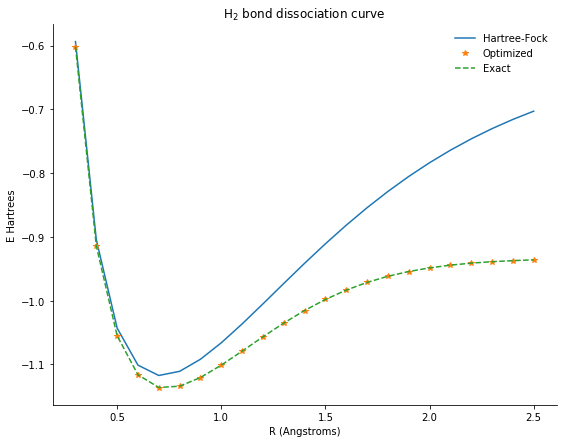

In [10]:
import matplotlib
import matplotlib.pyplot as pyplot
%matplotlib inline

# Plot the energy mean and std Dev
fig = pyplot.figure(figsize=(10,7))
bkcolor = '#ffffff'
ax = fig.add_subplot(1, 1, 1)
pyplot.subplots_adjust(left=.2)
ax.set_xlabel('R (Angstroms)')
ax.set_ylabel(r'E Hartrees')
ax.set_title(r'H$_2$ bond dissociation curve')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
bond_lengths = [float(x) for x in bond_lengths]
ax.plot(bond_lengths, hartree_fock_energies, label='Hartree-Fock')
ax.plot(bond_lengths, optimized_energies, '*', label='Optimized')
ax.plot(bond_lengths, exact_energies, '--', label='Exact')

ax.legend(frameon=False)
pyplot.show()